In [1]:
# Load environment variables from .env file
from dotenv import load_dotenv
import os
import logging

# Set the logging level for the 'neo4j' module to ERROR
logging.getLogger("neo4j").setLevel(logging.ERROR)

load_dotenv()

THRESHOLD = float(os.getenv("THRESHOLD", 0.7))

In [2]:
from neo4j import GraphDatabase
import pandas as pd
import os

URI = os.getenv("NEO4J_URI", "bolt://localhost:7687")
USER = os.getenv("NEO4J_USER", "neo4j")
PASSWORD = os.getenv("NEO4J_PASSWORD", "password")
DATABASE = os.getenv("NEO4J_DATABASE", "stocks")

driver = GraphDatabase.driver(URI, auth=(USER, PASSWORD))

def run_cypher(query, params=None):
    with driver.session(database=DATABASE) as session:
        result = session.run(query, params or {})
        return pd.DataFrame([r.data() for r in result])

In [3]:
# Quick sanity check
df_counts = run_cypher("""
MATCH (s:Stock)
WITH count(s) AS stocks
MATCH ()-[r:CO_MOVES_WITH]->()
RETURN stocks, count(r) AS relationships
""")
df_counts


,stocks,relationships
0,98,445065


In [4]:
# List available windows
df_windows = run_cypher("""
MATCH ()-[r:CO_MOVES_WITH]-()
RETURN r.window_id AS window_id,
       min(r.start) AS start,
       max(r.end)   AS end,
       count(*)     AS edges
ORDER BY start
""")
df_windows

,window_id,start,end,edges
0,W_20180102_20180123,2018-01-02,2018-01-23,344
1,W_20180105_20180126,2018-01-05,2018-01-26,418
2,W_20180110_20180131,2018-01-10,2018-01-31,444
3,W_20180116_20180205,2018-01-16,2018-02-05,1880
4,W_20180119_20180208,2018-01-19,2018-02-08,4424
...,...,...,...,...
654,W_20251022_20251111,2025-10-22,2025-11-11,400
655,W_20251027_20251114,2025-10-27,2025-11-14,396
656,W_20251030_20251119,2025-10-30,2025-11-19,492
657,W_20251104_20251124,2025-11-04,2025-11-24,1280


Text(0, 0.5, 'Number of Relationships')

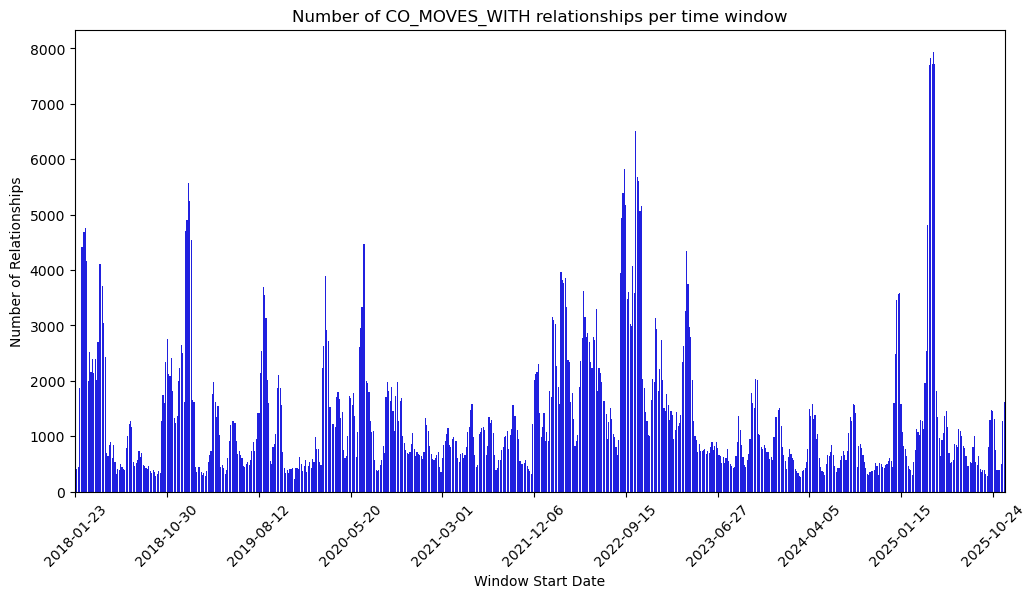

In [5]:
# Plot windows over time with seaborn
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
sns.barplot(data=df_windows, x="end", y="edges", color="blue")
plt.xticks(rotation=45)
# Reduce number of x-ticks for clarity
plt.gca().set_xticks(plt.gca().get_xticks()[::max(1, len(df_windows)//10)])
plt.title("Number of CO_MOVES_WITH relationships per time window")
plt.xlabel("Window Start Date")
plt.ylabel("Number of Relationships")

In [6]:
# Grab latest window
latest_window = run_cypher("""
MATCH ()-[r:CO_MOVES_WITH]-()
RETURN r.window_id AS window_id,
       max(r.end) AS end
ORDER BY end DESC
LIMIT 1
""")["window_id"].iloc[0]

latest_window


'W_20251107_20251128'

In [7]:
# Top correlated pairs
df_top_pairs = run_cypher("""
MATCH (s1:Stock)-[r:CO_MOVES_WITH {window_id: $window_id}]-(s2:Stock)
WHERE elementId(s1) < elementId(s2)
RETURN s1.ticker AS src,
       s2.ticker AS dst,
       r.corr    AS corr,
       r.sign    AS sign
ORDER BY abs(r.corr) DESC
LIMIT 50
""", {"window_id": latest_window})

df_top_pairs


,src,dst,corr,sign
0,MPC,VLO,0.938417,POS
1,BLK,URI,0.937265,POS
2,NUE,STLD,0.932521,POS
3,MU,NVDA,0.919985,POS
4,NVDA,WDC,0.919169,POS
5,COF,TROW,0.908425,POS
6,HOOD,TER,0.899978,POS
7,MTCH,WDAY,0.898805,POS
8,MU,WDC,0.892681,POS
9,EQT,EXE,0.889534,POS


In [8]:
# Degree distribution (how connected each stock is)
df_degrees = run_cypher("""
MATCH (s:Stock)-[r:CO_MOVES_WITH {window_id: $window_id}]-()
RETURN s.ticker AS ticker,
       s.sector AS sector,
       count(r) AS degree
ORDER BY degree DESC
""", {"window_id": latest_window})

df_degrees.head(20)

,ticker,sector,degree
0,BLK,Financial Services,44
1,MTCH,Communication Services,40
2,URI,Industrials,40
3,WDAY,Technology,39
4,NWS,Communication Services,37
5,ETN,Industrials,36
6,WAB,Industrials,34
7,FAST,Industrials,32
8,AMP,Financial Services,31
9,AOS,Industrials,31


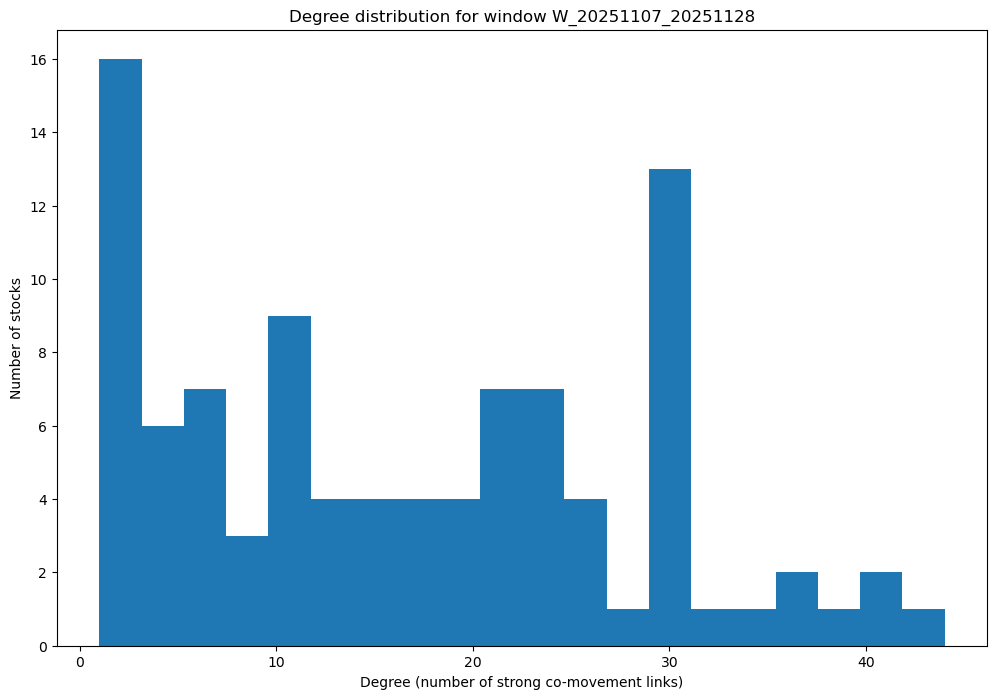

In [47]:
plt.figure(figsize=(12,8))
plt.hist(df_degrees["degree"], bins=20)
plt.xlabel("Degree (number of strong co-movement links)")
plt.ylabel("Number of stocks")
plt.title(f"Degree distribution for window {latest_window}")
plt.show()

In [10]:
max_edges = 200  # cap to avoid hairballs

df_edges = run_cypher("""
MATCH (s1:Stock)-[r:CO_MOVES_WITH {window_id: $window_id}]-(s2:Stock)
WHERE elementId(s1) < elementId(s2)
  AND abs(r.corr) >= $threshold
RETURN s1.ticker AS src,
       s2.ticker AS dst,
       r.corr    AS corr
ORDER BY abs(r.corr) DESC
LIMIT $max_edges
""", {
    "window_id": latest_window,
    "threshold": THRESHOLD,
    "max_edges": max_edges
})

df_edges.head()


,src,dst,corr
0,MPC,VLO,0.938417
1,BLK,URI,0.937265
2,NUE,STLD,0.932521
3,MU,NVDA,0.919985
4,NVDA,WDC,0.919169


In [11]:
# Add sector information to nodes
df_nodes = run_cypher("""
MATCH (s:Stock)
RETURN s.ticker AS ticker,
       s.sector AS sector
""")

sector_map = dict(zip(df_nodes["ticker"], df_nodes["sector"]))


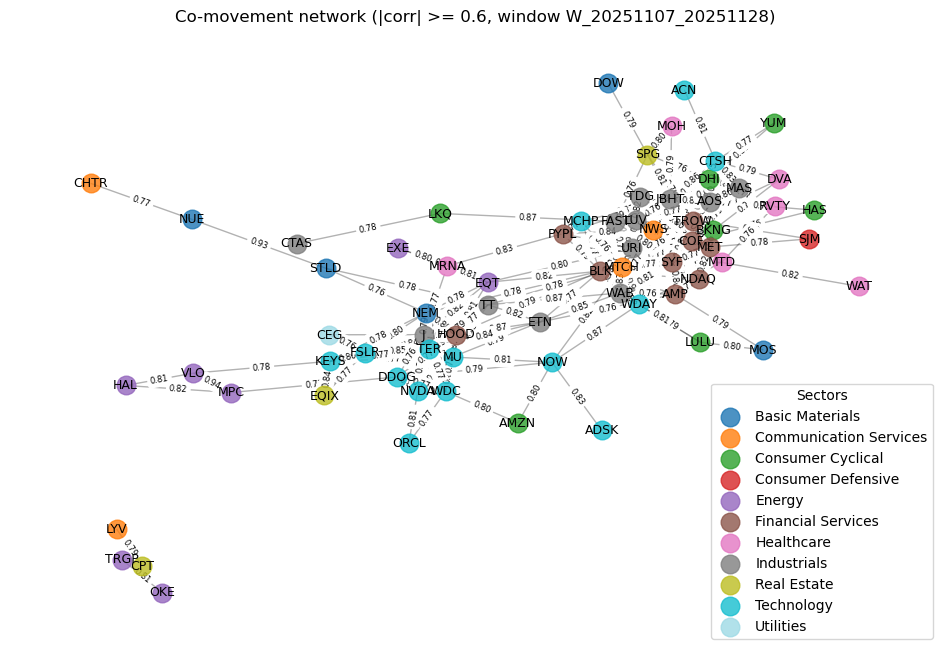

In [45]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib

G = nx.Graph()

# add edges with corr as weight
for _, row in df_edges.iterrows():
    G.add_edge(row["src"], row["dst"], weight=row["corr"])

# add node attributes (sector)
for node in G.nodes():
    G.nodes[node]["sector"] = sector_map.get(node, "Unknown")

# basic layout
pos = nx.spring_layout(G, k=0.2, iterations=50, seed=42)

plt.figure(figsize=(12, 8))

# Group nodes by sector and draw iteratively ---

# Identify all unique sectors
all_sectors = [G.nodes[n].get("sector", "Unknown") for n in G.nodes()]
unique_sectors = sorted(list(set(all_sectors)))

# Generate a color palette (using tab20 for distinct categorical colors)
color_map = matplotlib.colormaps['tab20'].resampled(len(unique_sectors))

# Loop through sectors and draw specific nodes
for i, sector in enumerate(unique_sectors):
    # Filter nodes belonging to this sector
    nodelist = [n for n in G.nodes() if G.nodes[n].get("sector", "Unknown") == sector]
    
    nx.draw_networkx_nodes(
        G, pos,
        nodelist=nodelist,
        node_size=180,
        node_color=[color_map(i)], # Assign specific color from map
        label=sector,
        alpha=0.8
    )

nx.draw_networkx_edges(G, pos, alpha=0.3)
nx.draw_networkx_labels(G, pos, font_size=9)

# Add labels for correlation values on edges
edge_labels = nx.get_edge_attributes(G, 'weight')
formatted_edge_labels = {k: f"{v:.2f}" for k, v in edge_labels.items()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=formatted_edge_labels, font_size=6)

# Enable the legend
plt.legend(scatterpoints=1, loc='best', title="Sectors")

plt.title(f"Co-movement network (|corr| >= {THRESHOLD}, window {latest_window})")
plt.axis("off")
plt.show()


In [13]:
# Sector to sector co-movement
df_sector_pairs = run_cypher("""
MATCH (s1:Stock)-[r:CO_MOVES_WITH {window_id: $window_id}]-(s2:Stock)
WHERE elementId(s1) < elementId(s2)
WITH s1.sector AS sector1,
     s2.sector AS sector2,
     r.corr    AS corr
WHERE sector1 IS NOT NULL AND sector2 IS NOT NULL
RETURN sector1,
       sector2,
       avg(corr) AS avg_corr,
       count(*)  AS edge_count
ORDER BY avg_corr DESC
""", {"window_id": latest_window})

df_sector_pairs.head(20)


,sector1,sector2,avg_corr,edge_count
0,Utilities,Financial Services,0.825419,1
1,Basic Materials,Basic Materials,0.795502,3
2,Real Estate,Communication Services,0.793774,1
3,Consumer Defensive,Financial Services,0.765288,2
4,Real Estate,Technology,0.755900,3
5,Technology,Technology,0.752087,38
6,Energy,Energy,0.750282,10
7,Financial Services,Financial Services,0.744215,40
8,Consumer Defensive,Consumer Cyclical,0.743740,1
9,Energy,Healthcare,0.741631,3


In [14]:
# Ego network for EQIX
ticker = "EQIX"

df_ego = run_cypher("""
MATCH (s:Stock {ticker: $ticker})-[r:CO_MOVES_WITH {window_id: $window_id}]-(n:Stock)
RETURN n.ticker AS neighbor,
       n.sector AS sector,
       r.corr   AS corr
ORDER BY abs(r.corr) DESC
""", {"ticker": ticker, "window_id": latest_window})

df_ego


,neighbor,sector,corr
0,KEYS,Technology,0.835001
1,FSLR,Technology,0.770334
2,EQT,Energy,0.710815
3,NEM,Basic Materials,0.682711
4,EXE,Energy,0.666331
5,VLO,Energy,0.640590
6,HOOD,Financial Services,0.638669


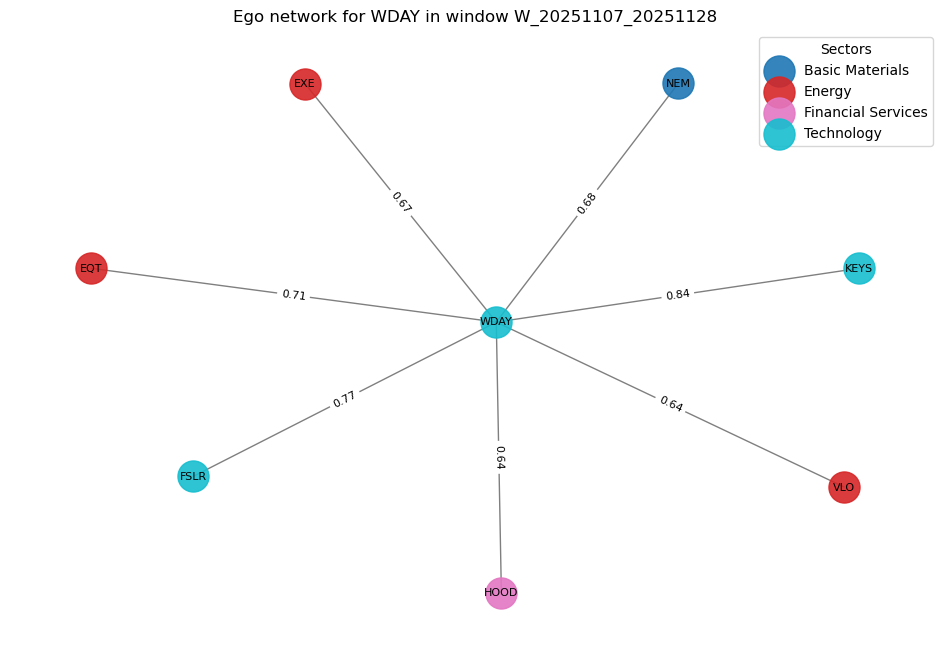

In [46]:

G_ego = nx.Graph()
for _, row in df_ego.iterrows():
    G_ego.add_edge(ticker, row["neighbor"], weight=row["corr"])

# Assign sector attributes to nodes
for node in G_ego.nodes():
    G_ego.nodes[node]["sector"] = sector_map.get(node, "Unknown")

pos = nx.spring_layout(G_ego, seed=42)

plt.figure(figsize=(12, 8))

# Draw nodes by sector for the legend

# Get unique sectors present in this specific graph
all_sectors = [G_ego.nodes[n]["sector"] for n in G_ego.nodes()]
unique_sectors = sorted(list(set(all_sectors)))

# Generate distinct colors
color_map = matplotlib.colormaps['tab10'].resampled(len(unique_sectors))

# Loop through sectors and draw them individually
for i, sector in enumerate(unique_sectors):
    # Filter nodes for this sector
    nodelist = [n for n in G_ego.nodes() if G_ego.nodes[n]["sector"] == sector]
    
    nx.draw_networkx_nodes(
        G_ego, pos,
        nodelist=nodelist,
        node_size=500,
        node_color=[color_map(i)],  # Assign specific color
        label=sector,
        alpha=0.9
    )

# Draw edges and text labels (done globally)
nx.draw_networkx_edges(G_ego, pos, alpha=0.5)
nx.draw_networkx_labels(G_ego, pos, font_size=8)

# Add edge labels for correlation values
edge_labels = nx.get_edge_attributes(G_ego, 'weight')
formatted_edge_labels = {k: f"{v:.2f}" for k, v in edge_labels.items()}
nx.draw_networkx_edge_labels(G_ego, pos, edge_labels=formatted_edge_labels, font_size=8)

# Create the legend
plt.legend(title="Sectors", loc="best")

plt.title(f"Ego network for {ticker} in window {latest_window}")
plt.axis("off")
plt.show()

## Density over time

In [16]:
df_windows = run_cypher("""
MATCH (s:Stock)-[r:CO_MOVES_WITH]-()
WITH r.window_id AS window_id,
     min(r.start) AS start,
     max(r.end)   AS end,
     collect(DISTINCT s) AS nodes,
     count(r) AS relHits
RETURN window_id,
       start,
       end,
       size(nodes) AS num_nodes,
       relHits / 2 AS num_edges
ORDER BY start
""")

df_windows


,window_id,start,end,num_nodes,num_edges
0,W_20180102_20180123,2018-01-02,2018-01-23,76,172
1,W_20180105_20180126,2018-01-05,2018-01-26,78,209
2,W_20180110_20180131,2018-01-10,2018-01-31,86,222
3,W_20180116_20180205,2018-01-16,2018-02-05,87,940
4,W_20180119_20180208,2018-01-19,2018-02-08,90,2212
...,...,...,...,...,...
654,W_20251022_20251111,2025-10-22,2025-11-11,91,200
655,W_20251027_20251114,2025-10-27,2025-11-14,91,198
656,W_20251030_20251119,2025-10-30,2025-11-19,90,246
657,W_20251104_20251124,2025-11-04,2025-11-24,93,640


In [17]:
# Compute density
df_windows["start"] = pd.to_datetime(df_windows["start"].astype(str))
df_windows["end"]   = pd.to_datetime(df_windows["end"].astype(str))


N = df_windows["num_nodes"]
E = df_windows["num_edges"]

df_windows["density"] = (2 * E) / (N * (N - 1))

df_windows[["window_id", "start", "num_nodes", "num_edges", "density"]].head()


,window_id,start,num_nodes,num_edges,density
0,W_20180102_20180123,2018-01-02,76,172,0.060351
1,W_20180105_20180126,2018-01-05,78,209,0.069597
2,W_20180110_20180131,2018-01-10,86,222,0.060739
3,W_20180116_20180205,2018-01-16,87,940,0.251270
4,W_20180119_20180208,2018-01-19,90,2212,0.552310


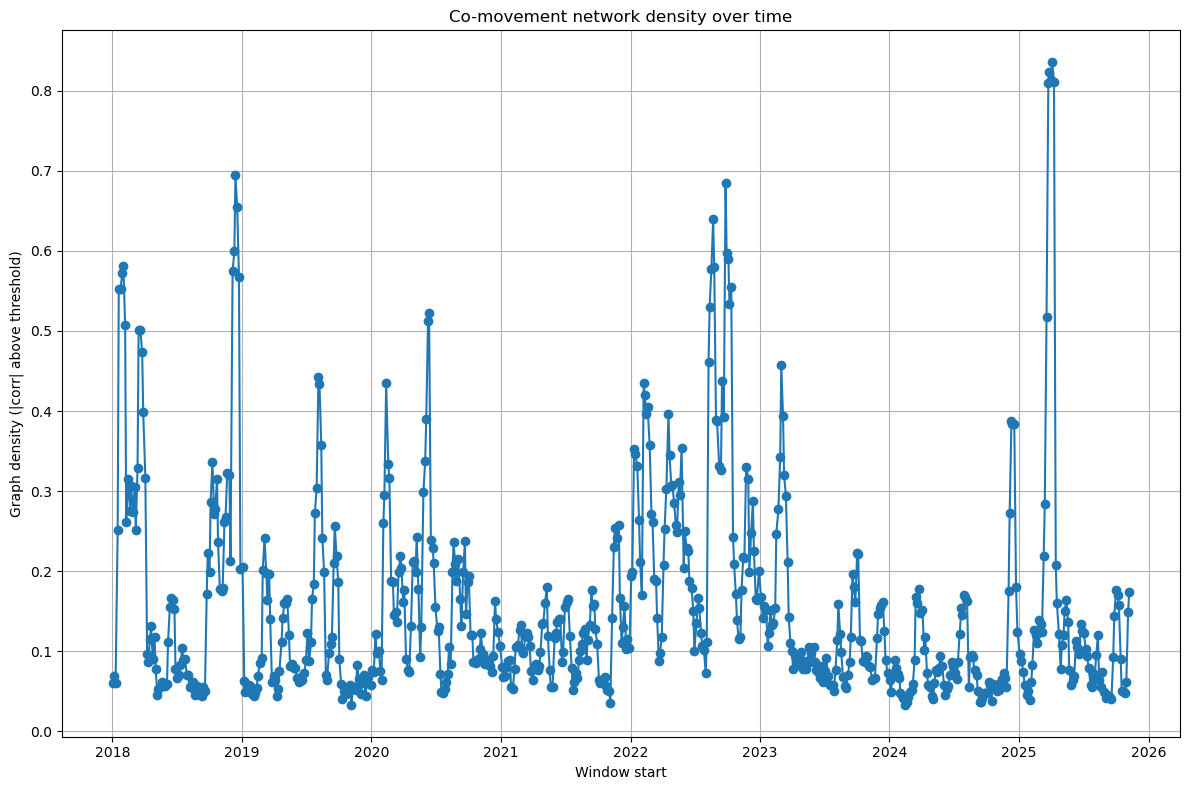

In [18]:
plt.figure(figsize=(12, 8))
plt.plot(df_windows["start"], df_windows["density"], marker="o")
plt.xlabel("Window start")
plt.ylabel("Graph density (|corr| above threshold)")
plt.title("Co-movement network density over time")
plt.grid(True)
plt.tight_layout()
plt.show()


## Cluster evolution (community structure over windows)

In [19]:
# Method for community detection with GDS
def detect_communities(window_id: str) -> pd.DataFrame:
    graph_name = f"g_{window_id}"

    # Drop graph if it already exists
    run_cypher("""
    CALL gds.graph.exists($graph_name) YIELD exists
    WITH exists
    WHERE exists
    CALL gds.graph.drop($graph_name) YIELD graphName
    RETURN graphName
    """, {"graph_name": graph_name})

    # New Cypher projection using gds.graph.project (function)
    run_cypher("""
    MATCH (s1:Stock)-[r:CO_MOVES_WITH {window_id: $window_id}]-(s2:Stock)
    WITH gds.graph.project(
      $graph_name,
      s1,
      s2,
      { relationshipProperties: r { .corr } },
      {}
    ) AS g
    RETURN g.graphName AS graph, g.nodeCount AS nodes, g.relationshipCount AS rels
    """, {
        "graph_name": graph_name,
        "window_id": window_id
    })

    # Run Louvain on the projected graph
    df_comm = run_cypher("""
    CALL gds.louvain.stream($graph_name, {relationshipWeightProperty: 'corr'})
    YIELD nodeId, communityId
    RETURN gds.util.asNode(nodeId).ticker AS ticker,
           communityId AS community
    """, {"graph_name": graph_name})

    # Drop the in-memory graph
    run_cypher("""
    CALL gds.graph.drop($graph_name) YIELD graphName
    """, {"graph_name": graph_name})

    df_comm["window_id"] = window_id
    return df_comm


In [20]:
from tqdm.auto import tqdm

# Run community detection for all windows
community_frames = []

for _, row in tqdm(df_windows.iterrows(), total=len(df_windows), desc="Detecting communities"):
    window_id = row["window_id"]
    df_comm = detect_communities(window_id)
    df_comm["start"] = row["start"]
    community_frames.append(df_comm)

df_communities = pd.concat(community_frames, ignore_index=True)
df_communities.head()


Detecting communities:   0%|          | 0/659 [00:00<?, ?it/s]

,ticker,community,window_id,start
0,ABT,55,W_20180102_20180123,2018-01-02
1,CHTR,55,W_20180102_20180123,2018-01-02
2,MCHP,55,W_20180102_20180123,2018-01-02
3,MTCH,44,W_20180102_20180123,2018-01-02
4,NOW,44,W_20180102_20180123,2018-01-02


In [21]:
# Print community evolution for selected tickers
focus = ["EQIX", "WDAY"]

df_focus = (
    df_communities[df_communities["ticker"].isin(focus)]
    .sort_values(["ticker", "start"])
)

pivot = df_focus.pivot_table(
    index="start",
    columns="ticker",
    values="community",
    aggfunc="first"
)

pivot.head()

ticker,EQIX,WDAY
start,,
2018-01-02,45.0,12.0
2018-01-05,NaN,29.0
2018-01-10,63.0,10.0
2018-01-16,75.0,47.0
2018-01-19,83.0,36.0


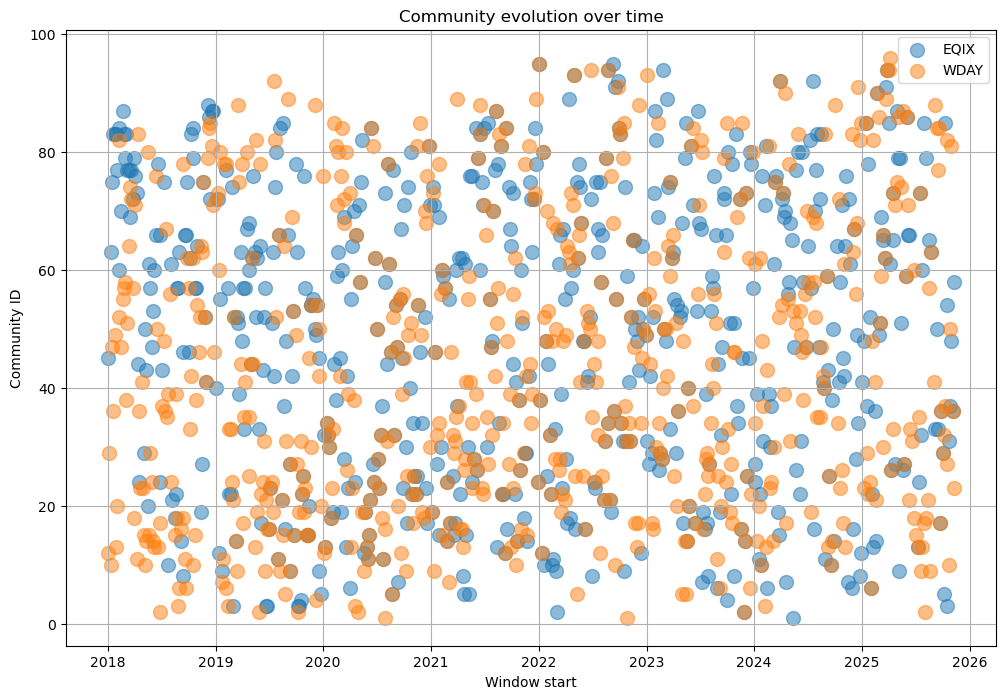

In [27]:
# Plot community evolution as a scatter plot
plt.figure(figsize=(12,8))
for ticker in pivot.columns:
    plt.scatter(pivot.index, pivot[ticker], label=ticker, s=100, alpha=0.5)
plt.title("Community evolution over time")
plt.ylabel("Community ID")
plt.xlabel("Window start")
plt.grid(True)
plt.legend()
plt.show()


In [28]:
# Pull global edges
df_global_edges = run_cypher("""
MATCH (s1:Stock)-[r:CO_MOVES_WITH]-(s2:Stock)
WHERE elementId(s1) < elementId(s2)
WITH s1, s2, avg(abs(r.corr)) AS w
WHERE w >= 0.3      // keep graph reasonably sparse
RETURN s1.ticker AS src,
       s2.ticker AS dst,
       w          AS weight
ORDER BY w DESC
""")

df_global_edges.head()


,src,dst,weight
0,NUE,STLD,0.836588
1,MPC,VLO,0.835047
2,COF,SYF,0.822900
3,DUK,XEL,0.801914
4,PNW,XEL,0.793068


In [29]:
# Compute layout
G_global = nx.Graph()
for _, row in df_global_edges.iterrows():
    G_global.add_edge(row["src"], row["dst"], weight=row["weight"])

# Single, stable 2D layout
pos = nx.spring_layout(G_global, k=0.3, iterations=100, seed=42)


In [30]:

# Rebuild df_windows
df_windows = run_cypher("""
MATCH ()-[r:CO_MOVES_WITH]-()
RETURN r.window_id AS window_id,
       min(r.start) AS start,
       max(r.end)   AS end
ORDER BY start
""")

df_windows["start"] = pd.to_datetime(df_windows["start"].astype(str))
df_windows["end"]   = pd.to_datetime(df_windows["end"].astype(str))

df_windows.head()

# Prepare community data with dates
# df_windows has: window_id, start, end...
df_communities = df_communities.merge(
    df_windows[["window_id", "start"]],
    on="window_id",
    how="left"
)

df_communities["start"] = pd.to_datetime(df_communities["start"].astype(str))
df_communities.head()

,ticker,community,window_id,start_x,start_y,start
0,ABT,55,W_20180102_20180123,2018-01-02,2018-01-02,2018-01-02
1,CHTR,55,W_20180102_20180123,2018-01-02,2018-01-02,2018-01-02
2,MCHP,55,W_20180102_20180123,2018-01-02,2018-01-02,2018-01-02
3,MTCH,44,W_20180102_20180123,2018-01-02,2018-01-02,2018-01-02
4,NOW,44,W_20180102_20180123,2018-01-02,2018-01-02,2018-01-02


In [31]:
# Static "frame per window" visualization

# latest window
one_window_id = df_windows.sort_values("start")["window_id"].iloc[-1]

df_w = df_communities[df_communities["window_id"] == one_window_id].copy()
df_w.head()


,ticker,community,window_id,start_x,start_y,start
60369,ABT,13,W_20251107_20251128,2025-11-07,2025-11-07,2025-11-07
60370,DVA,13,W_20251107_20251128,2025-11-07,2025-11-07,2025-11-07
60371,ACGL,90,W_20251107_20251128,2025-11-07,2025-11-07,2025-11-07
60372,AIZ,23,W_20251107_20251128,2025-11-07,2025-11-07,2025-11-07
60373,CINF,23,W_20251107_20251128,2025-11-07,2025-11-07,2025-11-07


In [32]:
# Build the colour map
communities = sorted(df_w["community"].unique())
comm_to_int = {c: i for i, c in enumerate(communities)}
df_w["color_idx"] = df_w["community"].map(comm_to_int)

# build arrays for plotting
xs, ys, colors = [], [], []

for _, row in df_w.iterrows():
    t = row["ticker"]
    if t in pos:  # some nodes might not appear in the global graph if isolated
        x, y = pos[t]
        xs.append(x)
        ys.append(y)
        colors.append(row["color_idx"])


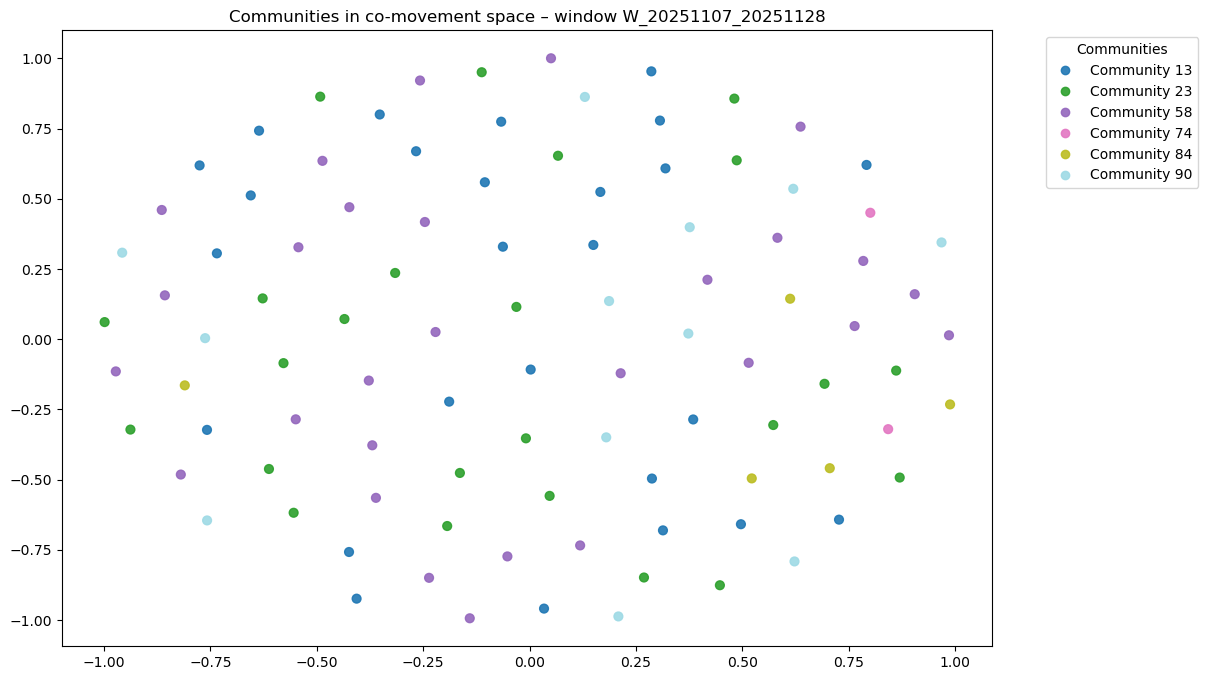

In [48]:
# Plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(xs, ys, c=colors, cmap="tab20", s=40, alpha=0.9)
# Add legend
handles, labels = scatter.legend_elements(num=len(communities))
legend_labels = [f"Community {c}" for c in communities]
plt.legend(handles, legend_labels, title="Communities", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title(f"Communities in co-movement space – window {one_window_id}")
#plt.axis("off")
plt.show()